In [1]:
import autograd.numpy as np
import autograd.scipy as sp

import autograd

import sys
#sys.path.insert(0, './../../../LinearResponseVariationalBayes.py')
sys.path.insert(0, './../')

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.ExponentialFamilies as ef

# My libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 

import functional_sensitivity_lib as fun_sens_lib
 

from scipy import spatial
import scipy.cluster.hierarchy as sch

import matplotlib.pyplot as plt
%matplotlib inline

import time
from tqdm import tqdm

from copy import deepcopy

from matplotlib.patches import Ellipse
import matplotlib.cm as cm

np.random.seed(453453)

import json 


# Load data

In [2]:
# set up R chunks 
# %load_ext rpy2.ipython
# %R require(ggplot2)

In [3]:
# load iris dataset 

from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

iris = datasets.load_iris(return_X_y= True)

iris_features = iris[0]

demean = True
if demean: 
    iris_features -= np.mean(iris_features, axis = 0)[None, :]

iris_species = iris[1]

dim = iris_features.shape[1]

In [4]:
# define colors that will be used for plotting later
# colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta']
# colors += colors

cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

In [5]:
# run PCA
pca_fit = PCA()
pca_fit.fit(iris_features)
pc_features = pca_fit.transform(iris_features)

In [6]:
def plot_clusters(x, y, cluster_labels, colors, fig, centroids = None, cov = None): 
    if np.all(cov != None): 
        assert len(np.unique(cluster_labels)) == np.shape(cov)[0]
    if np.all(centroids != None): 
        assert len(np.unique(cluster_labels)) == np.shape(centroids)[1] 
    
    unique_cluster_labels = np.unique(cluster_labels)
    n_clusters = len(unique_cluster_labels)
        
    # this would be so much easier if 
    # python lists supported logical indexing ... 
    cluster_labels_color = [colors[k] for n in range(len(x)) \
                            for k in range(n_clusters) \
                            if cluster_labels[n] == unique_cluster_labels[k]]
            
    # plot datapoints
    fig.scatter(x, y, c=cluster_labels_color, marker = '.')
    
    if np.all(centroids != None): 
        for k in range(n_clusters): 
            fig.scatter(centroids[0, k], centroids[1, k], marker = '+', color = 'black')
    
    if np.all(cov != None): 
        for k in range(n_clusters):  
            eig, v = np.linalg.eig(cov[k, :, :])
            ell = Ellipse(xy=(centroids[0, k], centroids[1, k]),
                  width=np.sqrt(eig[0]) * 6, height=np.sqrt(eig[1]) * 6,
                  angle=np.rad2deg(np.arctan(v[1, 0] / v[0, 0])))
            ell.set_facecolor('none')
            ell.set_edgecolor(colors[k])
            fig.add_artist(ell)
                

Text(0,0.5,'PC2')

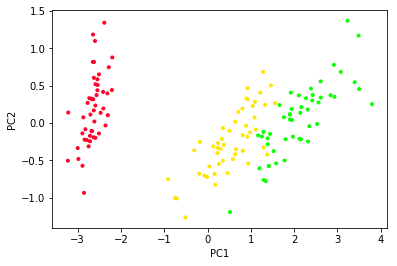

In [7]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')

Text(0,0.5,'Sepal width')

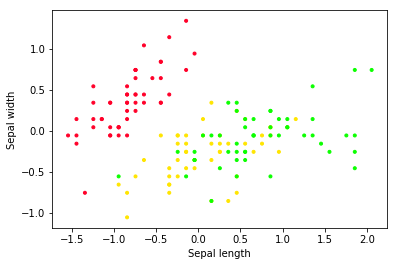

In [8]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
plot_clusters(iris_features[:, 0], iris_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('Sepal length')
fig.set_ylabel('Sepal width')

In [9]:
def transform_params_to_pc_space(pca_fit, centroids, cov):
    # centroids is dim x k_approx
    # infos is k_approx x dim x dim

    assert pca_fit.components_.shape[1] == centroids.shape[0]
    
    centroids_pc = pca_fit.transform(centroids.T)
    
    cov_pc = np.zeros(cov.shape)
    for k in range(cov.shape[0]):
        cov_pc[k, :, :] = np.dot(np.dot(pca_fit.components_, cov[k]), pca_fit.components_.T)
        
    # cov_pc = np.einsum('di, kij, ej -> kde', pca_fit.components_, cov, pca_fit.components_)
    
    
    return centroids_pc.T, cov_pc

# Set prior params

In [10]:
prior_params = gmm_utils.get_default_prior_params(dim)
prior_params['alpha'].set(4.0)
prior_params['prior_gamma_df'].set(8)
prior_params['prior_gamma_inv_scale'].set(np.eye(dim) * 0.62)

In [11]:
print(prior_params)

prior_params:
	alpha: 4.0
	prior_centroid_mean: 0.0
	prior_centroid_info: 0.1
	prior_gamma_df: 8
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]


# Set up model

In [12]:
k_approx = 12
gh_deg = 8
model = gmm_utils.DPGaussianMixture(iris_features, k_approx, prior_params, gh_deg, use_logitnormal_sticks=True)

# Set inits

In [13]:
set_truth = False

In [14]:
if set_truth: 
    # set to the true centroids: 
    centroid_init = np.zeros((dim, k_approx))
    info_init = np.zeros((k_approx, dim, dim))
    for k in range(k_approx): 
        if k < 3: 
            k_indx = np.argwhere(iris_species == k).flatten()
            centroid_k = np.mean(model.y[k_indx, :], axis = 0)

            resid_k = model.y[k_indx, :] - centroid_k

            cov_init = np.dot(resid_k.T, resid_k)

            info_init[k, :, :] = np.linalg.inv(cov_init)
            centroid_init[:, k] = centroid_k
        else: 
            info_init[k, :, :] = np.eye(dim)
    
    model.vb_params['global']['centroids'].set(centroid_init)
    model.vb_params['global']['gamma'].set(info_init)
    
    model.set_optimal_z()
    
    init_global_free_param = model.global_vb_params.get_free()
    
        
    
else: 
    # run k-means init
    n_kmeans_init = 50
    init_global_free_param = model.cluster_and_set_inits(n_kmeans_init = n_kmeans_init)


# look at initializations

In [15]:
init_clusters = np.argmax(model.vb_params['e_z'].get(), axis = 1)
init_centroids = model.vb_params['global']['centroids'].get()
init_cov = np.linalg.inv(model.vb_params['global']['gamma'].get())

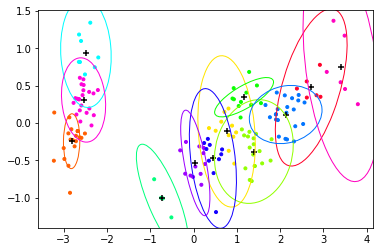

In [16]:
init_centroids_pc, init_cov_pc = transform_params_to_pc_space(pca_fit, init_centroids, init_cov)

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_clusters(pc_features[:, 0], pc_features[:, 1], init_clusters, \
            colors2, fig, \
             centroids = init_centroids_pc, cov = init_cov_pc)

In [17]:
print(np.linalg.norm(model.vb_params['global']['gamma'].get()))

10409.879713358841


# Optimize!

In [18]:
load_from_disc = True

In [19]:
if not load_from_disc: 
    t0 = time.time()
    best_param, kl_hessian, kl_hessian_corrected, \
    init_opt_time, newton_time, x_conv, f_conv, vb_opt = \
        model.optimize_full(init_global_free_param,
            init_max_iter=100,
            final_max_iter=500)
    t_newton = time.time() - t0

    print('done. ')
    
else: 

    full_data_fit_file = '../iris_fits/full_data_fits/iris_bnp_full_data_fit.json'
    with open(full_data_fit_file, 'r') as fp:
        fit_dict = json.load(fp)

    model = gmm_utils.get_model_from_checkpoint(fit_dict)
    model_ = gmm_utils.get_model_from_checkpoint(fit_dict)

    best_param = model.global_vb_params.get_free()

FileNotFoundError: [Errno 2] No such file or directory: '../iris_fits/full_data_fits/iris_bnp_full_data_fit.json'

In [ ]:
newton_results = deepcopy(model)

In [ ]:
print(prior_params)

In [ ]:
bnp_clusters = np.argmax(newton_results.vb_params['e_z'].get(), axis = 1)
bnp_centroids = newton_results.vb_params['global']['centroids'].get()

bnp_cluster_infos = newton_results.vb_params['global']['gamma'].get()
bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)

### look at bnp clusters

In [ ]:
bnp_centroids_pc, bnp_cluster_covs_pc = \
    transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)

In [ ]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

colors1_ = deepcopy(colors1)
colors1_[0] = colors1[2]
colors1_[1] = colors1[0]
colors1_[2] = colors1[1]

plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1_, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')

In [ ]:
# plt.scatter(pc_features[bnp_clusters == 0, 0], pc_features[bnp_clusters == 0, 1])

In [ ]:
# recall true clustering
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)

In [ ]:
model.set_from_global_free_par(newton_results.global_vb_params.get_free())
e_z = model.vb_params['e_z'].get()
co_cluster_mat = np.dot(e_z, e_z.T)

dis = (co_cluster_mat + 1) ** (-1)
dis[np.diag_indices_from(dis)] = 0
dis = spatial.distance.squareform(dis, checks=False)
y = sch.linkage(dis, method='average')
indx_best = sch.dendrogram(y, no_plot=True)["leaves"]

co_cluster_mat = co_cluster_mat[indx_best][:, indx_best]

plt.matshow(co_cluster_mat)


In [ ]:
# %%R -i bnp_clusters -i bnp_centroids -w 4 -h 3 --units in -r 200
# #     pca_centroids_init <- as.data.frame(predict(pca_results, t(init_centroids)))
# #     pca_centroids_init$cluster <- as.factor(seq(1, 10, by = 1))
# # TODO: plot the centroids too 

# # add our bnp clusterings to the dataframe
# df_pca$bnp_clusters <- as.factor(bnp_clusters)

# # plot
# ggplot() + geom_point(data = df_pca, aes(x = PC1, y = PC2, color = bnp_clusters), size = 0.5) + 
#     theme(legend.position="none") 

In [ ]:
cluster_weights = np.sum(newton_results.vb_params['e_z'].get(), axis = 0) / np.shape(model.y)[0]
plt.bar(np.arange(len(cluster_weights)), cluster_weights); 

In [ ]:
posterior_weights = model.get_e_cluster_probabilities()
plt.bar(np.arange(len(posterior_weights)), posterior_weights); 

In [ ]:
plt.hist(np.max(model.vb_params['e_z'].get(), axis = 1))

# Functional sensitivity

In [ ]:
best_param = newton_results.global_vb_params.get_free()
prior_free_params = newton_results.prior_params.get_free()

model.set_from_global_free_par(best_param)

moment_model = gmm_utils.InterestingMoments(deepcopy(model))
linear_sens = gmm_utils.LinearSensitivity(deepcopy(model), moment_model)

In [ ]:
model.set_from_global_free_par(best_param)
model.prior_params.set_free(prior_free_params)

In [ ]:
kl_hess_ev, kl_hess_evec = np.linalg.eig(linear_sens.kl_hessian)
print(np.min(kl_hess_ev), np.max(kl_hess_ev))

In [ ]:
def get_e_number_clusters_from_free_par(model, global_free_params, samples = 10000): 
    model.global_vb_params.set_free(global_free_params)
    return modeling_lib.get_e_number_clusters_from_logit_sticks_diffble(model.vb_params, samples = samples)

In [ ]:
# we examine the influence on the posterior stick lengths
def get_stick_length_from_free_param(model, free_par): 
    model.set_from_global_free_par(free_par)
    return ef.get_e_logitnormal(lognorm_means = model.vb_params['global']['v_sticks']['mean'].get(),
                lognorm_infos = model.vb_params['global']['v_sticks']['info'].get(),
                gh_loc = model.vb_params.gh_loc,
                gh_weights = model.vb_params.gh_weights)


# lets look at weights instead 
def get_kth_weight_from_free_param(model, free_par, k): 
    model.set_from_global_free_par(free_par)
    e_sticks = ef.get_e_logitnormal(lognorm_means = model.vb_params['global']['v_sticks']['mean'].get(),
                lognorm_infos = model.vb_params['global']['v_sticks']['info'].get(),
                gh_loc = model.vb_params.gh_loc,
                gh_weights = model.vb_params.gh_weights)
    
    return modeling_lib.get_kth_weight_from_sticks(np.array([e_sticks]), k)

g_eta = np.zeros((k_approx, model.global_vb_params.free_size()))
for k in range(k_approx): 
    get_g_eta = autograd.jacobian(get_kth_weight_from_free_param, argnum = 1)
    g_eta[k, :] = get_g_eta(model, best_param, k)

In [ ]:
get_g_eta_nclust = autograd.jacobian(get_e_number_clusters_from_free_par, argnum = 1)
g_eta_nclust = get_g_eta_nclust(model, best_param)

# Worst case influence

In [ ]:
worst_case_neg = lambda x : linear_sens.get_worst_case_perturbation_unscaled(g_eta = g_eta_nclust, \
                                                                      theta = x, \
                                                                      sign = -1)

worst_case_pos = lambda x : linear_sens.get_worst_case_perturbation_unscaled(g_eta = g_eta_nclust, \
                                                                      theta = x, \
                                                                      sign = 1)

In [ ]:
theta = np.linspace(0.01, 0.99, 100)

In [ ]:
epsilon = 0.01

In [ ]:
plt.plot(theta, np.dot(g_eta_nclust, linear_sens.total_influence_function(theta)), 'b--')
plt.plot(theta, worst_case_neg(theta).flatten() * epsilon, 'red')
plt.xlabel('x')
plt.ylabel('u(x)')
# plt.title('total influence on n_clusters')

In [ ]:
plt.plot(theta, np.dot(g_eta_nclust, linear_sens.total_influence_function(theta)), 'b--')
plt.plot(theta, worst_case_pos(theta).flatten(), 'red')
plt.xlabel('x')
plt.ylabel('u(x)')
# plt.title('total influence on n_clusters')

In [ ]:
# worst_case_neg_ = lambda x : linear_sens.get_worst_case_perturbation(g_eta = g_eta_nclust, \
#                                                                       theta = x, \
#                                                                       sign = -1, 
#                                                                     diffble = False) / np.sqrt(norm_neg)

# worst_case_pos_ = lambda x : linear_sens.get_worst_case_perturbation(g_eta = g_eta_nclust, \
#                                                                       theta = x, \
#                                                                       sign = 1, 
#                                                                    diffble = False) / np.sqrt(norm_pos)

# worst_case_fun_sens_mat_pos = np.zeros((len(best_param), k_approx - 1))
# worst_case_fun_sens_mat_neg = np.zeros((len(best_param), k_approx - 1))
# for k in range(k_approx - 1): 
#     worst_case_fun_sens_mat_pos[:, k] = \
#         linear_sens.get_functional_sensitivity(lambda x : worst_case_pos_(x), k)
    
#     worst_case_fun_sens_mat_neg[:, k] = \
#         linear_sens.get_functional_sensitivity(lambda x : worst_case_neg_(x), k)
    

In [ ]:
worst_case_fun_sens_mat_pos, worst_case_fun_sens_mat_neg = \
    linear_sens.get_worst_case_fun_sens(g_eta_nclust)

In [ ]:
# Perturb and re-optimize
epsilon = 100

model_worst_case_pos_pert = gmm_utils.DPGaussianMixture(
    model.y, model.k_approx, model.prior_params, gh_deg = 8, \
    use_bnp_prior = model.vb_params.use_bnp_prior, \
    use_logitnormal_sticks = model.vb_params.use_logitnormal_sticks, \
    u = lambda x : worst_case_neg(x) * epsilon)

pos_pert_worst_case_opt_free_param = \
    model_worst_case_pos_pert.optimize_full(best_param, init_max_iter=100, final_max_iter=500)[0]


In [ ]:
lr_free_param_diff_vec = np.matmul(worst_case_fun_sens_mat_pos, epsilon * np.ones(k_approx - 1))

diff_vec = pos_pert_worst_case_opt_free_param - best_param
lr_diff_vec = deepcopy(lr_free_param_diff_vec)
plt.plot(diff_vec, lr_diff_vec, 'r+')
plt.plot(diff_vec, diff_vec, 'k')    
plt.xlabel('true diff')
plt.ylabel('lr diff')


In [ ]:
get_e_number_clusters_from_free_par(model, best_param)

In [ ]:
print('perturbed e_number_clusters:', 
get_e_number_clusters_from_free_par(model, pos_pert_worst_case_opt_free_param))

In [ ]:
print('linear response e_number_clusters:', 
      get_e_number_clusters_from_free_par(model, lr_free_param_diff_vec + best_param))